In [1]:
import os
import torch
import torchvision.models as models
import torch.nn as nn
# from deepproblog.dataset import Dataset, DataLoader, QueryDataset
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as TorchDataset
from deepproblog.dataset import Dataset as DPLDataset
from problog.logic import Term, Constant, Var, list2term
from deepproblog.dataset import ImageDataset
from deepproblog.evaluate import get_confusion_matrix
from torch.amp.autocast_mode import autocast
from torchvision import models, transforms, datasets
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from deepproblog.dataset import DataLoader as DPLDataLoader

import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
from deepproblog.utils.stop_condition import EpochStop
from deepproblog.optimizer import SGD

from deepproblog.model import Model
from deepproblog.network import Network
from deepproblog.engines import ExactEngine
from deepproblog.query import Query
from deepproblog.train import train_model
import torch.nn as nn
import torch.nn.functional as F

from torch.amp.grad_scaler import GradScaler
from torch.amp.autocast_mode import autocast

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import glob
from retinaface import RetinaFace
import csv

c:\Users\jarne\miniconda3\envs\dpl_base\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.5 when it was built against 1.14.6, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
# GLOBAL VARS
dataset_size = None
lr_faces = 1e-4
lr_scenes = 1e-4
lr_combination_model = 5e-4
lr_model = 1e-4
batch_size = 32
log_iter = 2
epochs = 30
global_emotion_label = 'emo8'
nr_clusters = 9

In [3]:
# Directories
script_dir = os.getcwd()
print("script_dir:", script_dir)
base_dir = os.path.dirname(os.path.dirname(script_dir))
print("base_dir:", base_dir)
prolog_dir = os.path.join(base_dir, "prolog")
data_dir = os.path.join(base_dir, "data")
print("data_dir:", data_dir)
findingemo_dir = os.path.join(data_dir, "FindingEmo_Images")
print("findingemo_dir:", findingemo_dir)
prolog_dir = os.path.join(base_dir, "code", "prolog")
print("prolog_dir:", prolog_dir)
model_dir = os.path.join(base_dir, "code", "models")
print("model_dir:", model_dir)
cropped_faces_dir = os.path.join(findingemo_dir, "faces")
print("cropped_faces_dir:", cropped_faces_dir)

script_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\notebooks
base_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition
data_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data
findingemo_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data\FindingEmo_Images
prolog_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\prolog
model_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\models
cropped_faces_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data\FindingEmo_Images\faces


In [4]:
df = pd.read_pickle(os.path.join(script_dir, "clean_findingemo.pkl"))
print("Dataframe loaded. Number of entries:", len(df))

Dataframe loaded. Number of entries: 25867


In [5]:
EMOTION_SETS = [["Serenity", "Joy", "Ecstasy"],
                    ["Acceptance", "Trust", "Admiration"],
                    ["Apprehension", "Fear", "Terror"],
                    ["Distraction", "Surprise", "Amazement"],
                    ["Pensiveness", "Sadness", "Grief"],
                    ["Boredom", "Disgust", "Loathing"],
                    ["Annoyance", "Anger", "Rage"],
                    ["Interest", "Anticipation", "Vigilance"]]
                
def emo_8_mapping(e):
    for leaf in EMOTION_SETS:
        if e in leaf:
            return leaf[1]
        
def emo_3_mapping(v):
    if v < -1:
        return "sad"
    if v > 1:
        return "happy"
    else:
        return "neutral"

In [6]:
if global_emotion_label == 'emo8':
    df['emotion'] = df['emotion'].apply(emo_8_mapping).str.lower()
if global_emotion_label == 'emotion':
    df['emotion'] = df['emotion'].str.lower()
if global_emotion_label == 'emo3':
    df['emotion'] = df['valence'].apply(emo_3_mapping).str.lower()

In [7]:
df.head()

,image_path,tags,age,valence,arousal,emotion,dec_factors,ambiguity
0,Run_2/Loving toddlers sports/haiti-kids.jpg,Undefined,Children,0,2,trust,"BodyLanguage,FacialExpression",0
1,Run_2/Frustrated forty-something office/team-w...,Undefined,Young Adults,0,2,anticipation,FacialExpression,0
2,Run_1/Violent youth festival/1042373588.jpg,Undefined,Young Adults,2,2,anticipation,BodyLanguage,3
3,Run_2/Remorseful toddlers court of law/dcfs-co...,Undefined,Adults,1,2,anticipation,"BodyLanguage,FacialExpression",4
4,Run_2/Shame elderly sports/3364887-46.jpg,Undefined,Adults,0,3,fear,ConflictCtxtPerson,0


In [8]:
len(df)

25867

In [9]:
if dataset_size is not None:
    df = df.iloc[:dataset_size]

In [10]:
fe_labels = df['emotion'].unique().tolist()
fe_labels.sort()
print("Emotion labels:", fe_labels)

Emotion labels: ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']


In [11]:
fer_classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [12]:
# Create a dictionary with the average valence arousal values for each emotion label
emotion_va = {}

for emo in fe_labels:
    emo_df = df[df['emotion'] == emo]
    avg_valence = emo_df['valence'].mean() + 3
    avg_arousal = emo_df['arousal'].mean()
    emotion_va[emo] = (avg_valence, avg_arousal)

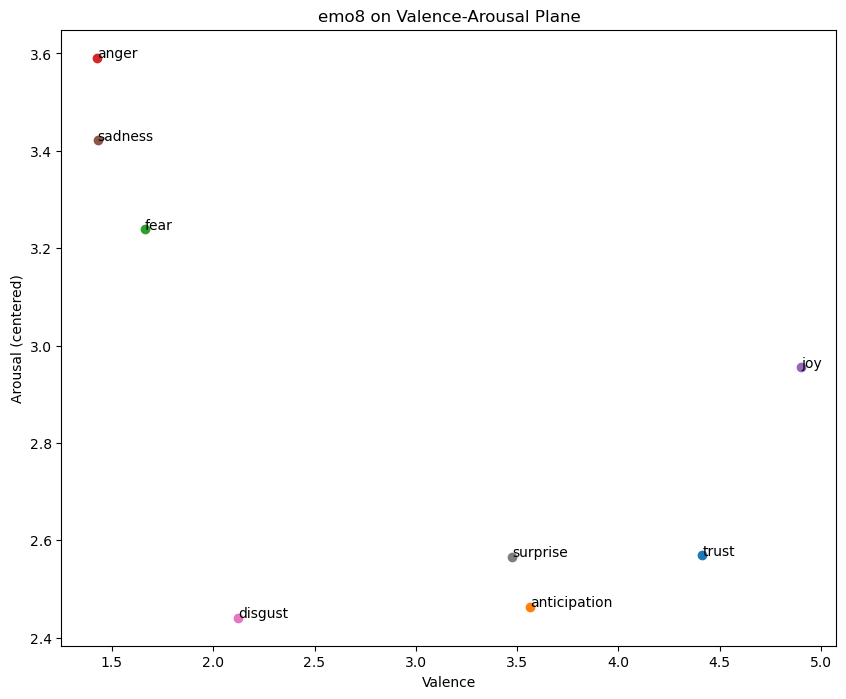

In [13]:
plt.figure(figsize=(10, 8))
for emo in df['emotion'].unique():
    avg_valence, avg_arousal = emotion_va[emo]
    plt.scatter(avg_valence, avg_arousal, label=emo)
    plt.text(avg_valence, avg_arousal, emo)
plt.xlabel('Valence')
plt.ylabel('Arousal (centered)')
plt.title(f'{global_emotion_label} on Valence-Arousal Plane')
plt.show()

In [14]:
# Load category names
scene_categories_path = os.path.join(data_dir, "places365/categories_places365.txt")
with open(scene_categories_path) as f:
    scene_categories = [line.strip().split(' ')[0][3:] for line in f]
    # If there is a / in the category name, replace it with _
    scene_categories = [cat.replace('/', '_') for cat in scene_categories]
print("Length of scene categories:", len(scene_categories))  # Should be 365

Length of scene categories: 365


In [15]:
# get the counts of the labels of emotion
df['emotion'].value_counts()

emotion
joy             7024
anticipation    5901
trust           3549
sadness         2665
anger           2439
fear            2401
disgust         1000
surprise         888
Name: count, dtype: int64

In [16]:
if dataset_size is not None:
    N = dataset_size
else:
    N = len(df)
    
indices = list(range(N))

train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)
print("Train indices length:", len(train_indices))
print("Test indices length:", len(test_indices))

Train indices length: 20693
Test indices length: 5174


In [17]:
print(torch.cuda.is_available())
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# let cuDNN pick the fastest kernels for this image size
torch.backends.cudnn.benchmark = True

True


In [18]:
from transformers import AutoImageProcessor, AutoModelForImageClassification, AutoConfig


emotion_transform = AutoImageProcessor.from_pretrained("trpakov/vit-face-expression", use_fast=True)
face_model_base = AutoModelForImageClassification.from_pretrained("trpakov/vit-face-expression")
face_model_base.to(DEVICE)
config = AutoConfig.from_pretrained("trpakov/vit-face-expression")
print(config.id2label)

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


In [19]:
class FacesDataset(ImageDataset):
    def __init__(self, indices):
        super().__init__(os.path.join(findingemo_dir, "faces_5"), extension="jpg", transform=emotion_transform)
        self.indices = indices
    
    def __getitem__(self, i):
        if isinstance(i, tuple):
            i = tuple(int(x.value) if isinstance(x, Constant) else x for x in i)
        
        tensor = super().__getitem__("img_{}_face_{}".format(*i))
        return tensor['pixel_values'][0]
    
    def __len__(self):
        return len(self.indices)
    
    def to_query(self, i):
        pass
    
faces_dataset = FacesDataset(indices)

In [20]:
scene_processor = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load pretrained Places365 ResNet18
scene_model_base = models.resnet18(num_classes=365)
weights_url = "http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar"
checkpoint = torch.hub.load_state_dict_from_url(weights_url, map_location="cpu")
state_dict = {k.replace("module.", ""): v for k, v in checkpoint["state_dict"].items()}
scene_model_base.load_state_dict(state_dict)
scene_model_base.to(DEVICE)
print("Loaded pretrained models")

Loaded pretrained models


In [21]:
from abc import ABC, abstractmethod
from pathlib import Path

class ImageDatasetExtension(DPLDataset, ABC):
    def __init__(self, root, extension="png", transform=None):
        super().__init__()
        self.root = Path(root)
        self.transform = transform
        self.extension = extension

    def __getitem__(self, index, extension=None):
        if type(index) is tuple:
            index = index[0]
        if extension is None:
            extension = self.extension
        p = self.root / "{}.{}".format(index, extension)
        with open(p, "rb") as f:
            img = Image.open(f)
            img = img.convert("RGB")
            if self.transform is not None:
                img = self.transform(img)
        return img

In [22]:
class SceneDataset(ImageDatasetExtension):
    def __init__(self, indices):
        super().__init__(os.path.join(findingemo_dir), extension="jpg", transform=scene_processor)
        self.indices = indices

    def __getitem__(self, i):
        if isinstance(i, tuple):
            i = tuple(int(x.value) if isinstance(x, Constant) else x for x in i)
        img_path = df.loc[i]['image_path']
        extension = img_path.rsplit('.', 1)[1]
        img_path_no_ext = img_path.rsplit('.', 1)[0]
        tensor = super().__getitem__(img_path_no_ext, extension = extension)
        return tensor
    
    def __len__(self):
        return len(self.indices)
    
    def to_query(self, i):
        pass

scenes_dataset = SceneDataset(indices)

In [23]:
df_boxes = pd.read_csv(os.path.join(findingemo_dir, "face_boxes_5.csv"))
# Based on boxes_df we can add the column nr_faces for each original image in df
df['nr_faces'] = df.index.map(df_boxes['index'].value_counts()).fillna(0).astype(int)

In [24]:
def save_pretrained_logits_separately(indices, output_dir):
    """
    Save pre-computed logits from pretrained models to separate files.
    
    Args:
        indices: list of sample indices to process
        output_dir: base directory to save the logits
    """
    # Create output directories
    scene_dir = os.path.join(output_dir, "scenes")
    faces_dir = os.path.join(output_dir, "faces")
    os.makedirs(scene_dir, exist_ok=True)
    os.makedirs(faces_dir, exist_ok=True)
    
    # Set models to eval mode
    face_model_base.eval()
    scene_model_base.eval()
    
    for img_idx in tqdm(indices, desc="Saving pretrained logits"):
        # ----- PROCESS SCENE -----
        scene_img = scenes_dataset[(img_idx,)].to(DEVICE).unsqueeze(0)  # (1, C, H, W)
        
        with torch.no_grad():
            scene_logits = scene_model_base(scene_img).squeeze(0)  # (365,)
        
        # Save scene logits
        scene_file = os.path.join(scene_dir, f"scene_{img_idx}.pt")
        torch.save(scene_logits.cpu(), scene_file)
        
        # ----- PROCESS FACES -----
        face_rows = df_boxes[df_boxes['index'] == img_idx].sort_values('face_rank')
        
        for _, row in face_rows.iterrows():
            face_rank = int(row['face_rank'])
            face_tensor = faces_dataset[(img_idx, face_rank)]
            
            with torch.no_grad():
                face_tensor = face_tensor.to(DEVICE).unsqueeze(0)  # (1, C, H, W)
                outputs = face_model_base(face_tensor)  # Returns ImageClassifierOutput
                face_logits = outputs.logits.squeeze(0)  # (7,)
            
            # Save face logits
            face_file = os.path.join(faces_dir, f"face_{img_idx}_{face_rank}.pt")
            torch.save(face_logits.cpu(), face_file)
    
    print(f"\nLogits saved to:")
    print(f"  Scenes: {scene_dir}")
    print(f"  Faces: {faces_dir}")

# Usage:
# save_pretrained_logits_separately(indices, output_dir=os.path.join(data_dir, "pretrained_logits"))

In [25]:
get_category_name = lambda idx: scene_categories[idx]

In [26]:
def show_pretrained_model_predictions_on_sample(sample_idx):
    row = df.iloc[sample_idx]
    img_path = os.path.join(findingemo_dir, row['image_path'])
    img = Image.open(img_path).convert("RGB")
    
    # Convert to numpy array for drawing
    img_array = np.array(img)
    
    # Get all face boxes for this image
    face_boxes = df_boxes[df_boxes['index'] == sample_idx].sort_values('face_rank')
    
    # Draw bounding boxes and predictions on the image
    for _, box_row in face_boxes.iterrows():
        x1, y1, x2, y2 = int(box_row['x1']), int(box_row['y1']), int(box_row['x2']), int(box_row['y2'])
        face_rank = int(box_row['face_rank'])
        
        model_output = torch.load(os.path.join(data_dir, "pretrained_logits", "faces", f"face_{sample_idx}_{face_rank}.pt")).to(DEVICE).unsqueeze(0)
        probs_output = torch.softmax(model_output, dim=1)
        probs = probs_output[0].cpu().detach().numpy()
        
        # Get top prediction
        top_idx = np.argmax(probs)
        top_label = f"{fer_classes[top_idx]}: {probs[top_idx]:.2f}"
        
        # Draw rectangle
        cv2.rectangle(img_array, (x1, y1), (x2, y2), (0, 255, 0), 2)
        
        # Calculate text size for better positioning
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.8
        thickness = 2
        (text_width, text_height), baseline = cv2.getTextSize(top_label, font, font_scale, thickness)
        
        # Position text above the box if there's space, otherwise below
        if y1 - text_height - 10 > 0:
            text_y = y1 - 10
        else:
            text_y = y2 + text_height + 10
        
        # Draw text with background for better visibility
        cv2.rectangle(img_array, (x1, text_y - text_height - 5), 
                    (x1 + text_width + 5, text_y + 5), (0, 255, 0), -1)
        cv2.putText(img_array, top_label, (x1, text_y), 
                    font, font_scale, (0, 0, 0), thickness)
        
    # Display image with bounding boxes and predictions
    plt.figure(figsize=(15, 10))
    plt.imshow(img_array)
    plt.axis('off')
    plt.title(f"Image Index: {sample_idx}, Valence: {row['valence']}, Arousal: {row['arousal']}, Emotion: {row['emotion']}", fontsize=16)
    plt.show()

    scene_logits = torch.load(os.path.join(data_dir, "pretrained_logits", "scenes", f"scene_{sample_idx}.pt")).to(DEVICE)
    scene_probs = torch.softmax(scene_logits, dim=0)
   

    # Show top 3 from base model (365 categories)
    top3_base = torch.topk(scene_probs, 3)
    print("Base model (365 categories):")
    for prob, idx in zip(top3_base.values.cpu(), top3_base.indices.cpu()):
        print(f"  {get_category_name(idx)}: {prob:.4f}")
    print("")


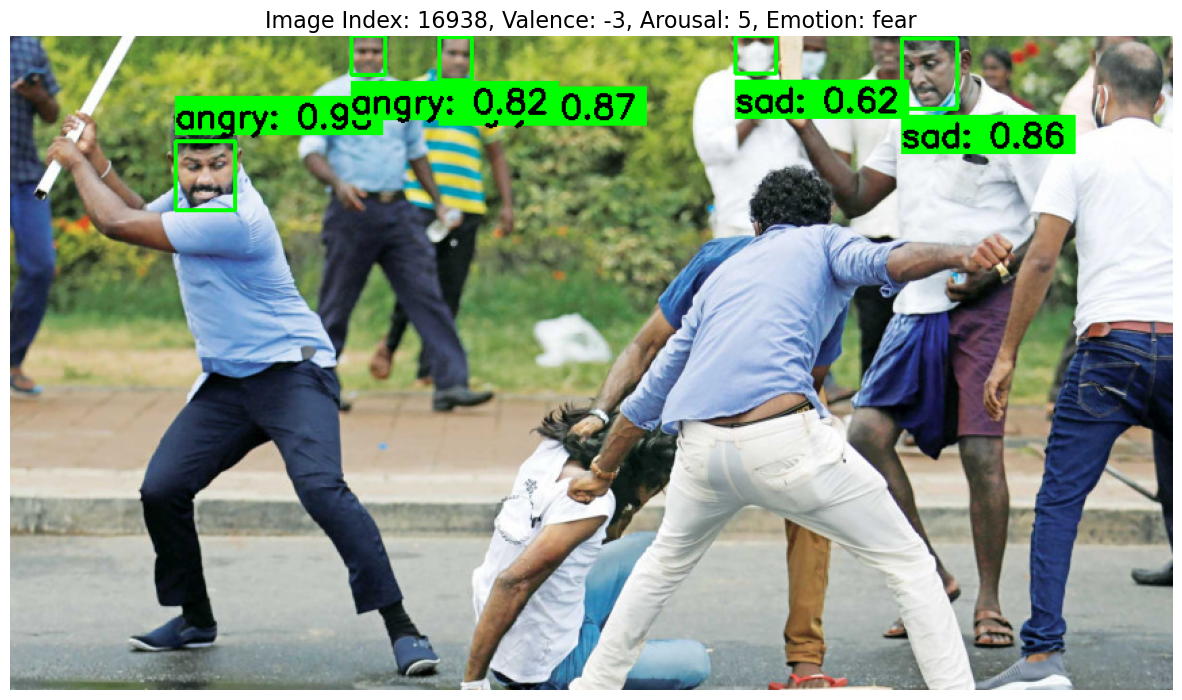

Base model (365 categories):
  martial_arts_gym: 0.4330
  baseball_field: 0.2028
  golf_course: 0.0780



In [27]:
show_pretrained_model_predictions_on_sample(np.random.choice(test_indices))

# Baseline model using the logits of the base models directly

## Torch

In [28]:
from deepproblog.utils.standard_networks import MLP

baseline_model = MLP(
    372,        # input size
    256, 128,   # hidden layers
    8,          # number of emotion classes
    activation=nn.ReLU,
    softmax=False,   # important!
    batch=True
)
criterion = nn.CrossEntropyLoss()
baseline_model.to(DEVICE)
optimizer = optim.Adam(baseline_model.parameters(), lr=1e-3)

In [29]:
class BaselineFeatureDataset(TorchDataset):
    """Dataset that provides pre-computed features as tensors"""
    def __init__(self, indices, feature_dir):
        self.indices = indices
        self.feature_dir = feature_dir
    
    def __getitem__(self, idx):
        if isinstance(idx, (tuple, list)):
            idx = idx[0]
        if isinstance(idx, Constant):
            idx = int(idx.value)
        idx = self.indices[idx]    
        scene_prediction_file = os.path.join(self.feature_dir, "scenes", f"scene_{idx}.pt")
        scene_features = torch.load(scene_prediction_file).to(DEVICE)
        
        label = df.loc[idx]['emotion']
        label_idx = fe_labels.index(label)
        
        face_features_list = []
        for _, box_row in df_boxes[df_boxes['index'] == idx].sort_values('face_rank').iterrows():
            face_rank = int(box_row['face_rank'])
            face_prediction_file = os.path.join(self.feature_dir, "faces", f"face_{idx}_{face_rank}.pt")
            face_features = torch.load(face_prediction_file).to(DEVICE)
            face_features_list.append(face_features)

        # if no faces: use neutral
        if len(face_features_list) == 0:
            face_avg = torch.zeros(7).to(DEVICE)
            face_avg[4] = 1.0   # neutral
        else:
            face_avg = torch.stack(face_features_list).mean(dim=0)  # (7,)

        features = torch.cat([face_avg, scene_features], dim=0)  # (372,)

        return features.to(DEVICE), label_idx

    def __len__(self):
        return len(self.indices)

In [30]:
baseline_features_train = BaselineFeatureDataset(train_indices, feature_dir=os.path.join(data_dir, "pretrained_logits"))
baseline_features_test = BaselineFeatureDataset(test_indices, feature_dir=os.path.join(data_dir, "pretrained_logits"))

In [31]:
baseline_train_loader = DataLoader(baseline_features_train, batch_size=32, shuffle=True)
baseline_test_loader = DataLoader(baseline_features_test, batch_size=32, shuffle=False)

In [32]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for x, y in tqdm(loader, desc="Training", leave=False):
        x = x.to(DEVICE).float()
        y = y.to(DEVICE)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        total_correct += (preds == y).sum().item()
        total_samples += x.size(0)

    return total_loss / total_samples, total_correct / total_samples

In [33]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

def evaluate_with_metrics(model, loader, criterion):
    """Enhanced evaluate function that returns metrics"""
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for x, y in tqdm(loader, desc="Evaluating", leave=False):
            x = x.to(DEVICE).float()
            y = y.to(DEVICE)

            logits = model(x)
            loss = criterion(logits, y)

            total_loss += loss.item() * x.size(0)
            preds = logits.argmax(dim=1)

            all_labels.extend(y.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

            total_correct += (preds == y).sum().item()
            total_samples += x.size(0)

    # Calculate metrics
    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None, labels=range(len(fe_labels))
    )
    
    # Overall metrics
    accuracy = total_correct / total_samples
    avg_loss = total_loss / total_samples
    
    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'y_true': y_true,
        'y_pred': y_pred,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'support': support
    }


def print_detailed_metrics(results, label_names):
    """Print detailed metrics in a nice format"""
    print(f"\n{'='*70}")
    print(f"Overall Metrics:")
    print(f"{'='*70}")
    print(f"Loss:     {results['loss']:.4f}")
    print(f"Accuracy: {results['accuracy']:.4f}")
    
    print(f"\n{'='*70}")
    print(f"Per-Class Metrics:")
    print(f"{'='*70}")
    print(f"{'Emotion':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
    print(f"{'-'*70}")
    
    for i, label in enumerate(label_names):
        print(f"{label:<15} {results['precision'][i]:<12.4f} "
              f"{results['recall'][i]:<12.4f} {results['f1'][i]:<12.4f} "
              f"{int(results['support'][i]):<10}")
    
    # Macro averages
    print(f"{'-'*70}")
    print(f"{'Macro Avg':<15} {results['precision'].mean():<12.4f} "
          f"{results['recall'].mean():<12.4f} {results['f1'].mean():<12.4f} "
          f"{int(results['support'].sum()):<10}")
    
    # Weighted averages
    weights = results['support'] / results['support'].sum()
    weighted_precision = (results['precision'] * weights).sum()
    weighted_recall = (results['recall'] * weights).sum()
    weighted_f1 = (results['f1'] * weights).sum()
    
    print(f"{'Weighted Avg':<15} {weighted_precision:<12.4f} "
          f"{weighted_recall:<12.4f} {weighted_f1:<12.4f} "
          f"{int(results['support'].sum()):<10}")


def plot_confusion_matrix(cm, label_names, normalize=False):
    """Plot confusion matrix with better formatting"""
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
        title = 'Normalized Confusion Matrix'
    else:
        fmt = 'd'
        title = 'Confusion Matrix'
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=label_names, yticklabels=label_names,
                cbar_kws={'label': 'Count' if not normalize else 'Proportion'})
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('True', fontsize=12)
    plt.title(title, fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [34]:
# EPOCHS = 5

# for epoch in range(EPOCHS):
#     print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    
#     # Train
#     train_loss, train_acc = train_epoch(baseline_model, baseline_train_loader, optimizer, criterion)
#     print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    
#     # Evaluate
#     results = evaluate_with_metrics(baseline_model, baseline_test_loader, criterion)
#     print_detailed_metrics(results, fe_labels)
    
#     # Plot confusion matrix
#     plot_confusion_matrix(results['confusion_matrix'], fe_labels, normalize=True)

# torch.save(baseline_model.state_dict(), os.path.join(model_dir, "baseline_emotion_model.pth"))
# Load the trained baseline model weights
# baseline_dpl.load_state_dict(torch.load(os.path.join(model_dir, "baseline_emotion_model_2.pth")))

## DPL

In [35]:
class DeviceAwareModule(nn.Module):
    """Wrapper that automatically handles device placement for any module"""
    def __init__(self, module):
        super().__init__()
        self.module = module
    
    def forward(self, *args, **kwargs):
        # Move all tensor inputs to model's device
        device = next(self.module.parameters()).device
        
        def to_device(x):
            if isinstance(x, torch.Tensor):
                return x.to(device)
            elif isinstance(x, (list, tuple)):
                return type(x)(to_device(item) for item in x)
            elif isinstance(x, dict):
                return {k: to_device(v) for k, v in x.items()}
            return x
        
        args = to_device(args)
        kwargs = to_device(kwargs)
        return self.module(*args, **kwargs)
    
    def __getattr__(self, name):
        try:
            return super().__getattr__(name)
        except AttributeError:
            return getattr(self.module, name)

In [36]:
LABEL_TO_ID = {emo: i for i, emo in enumerate(fe_labels)}
print("LABEL_TO_ID:", LABEL_TO_ID)

LABEL_TO_ID: {'anger': 0, 'anticipation': 1, 'disgust': 2, 'fear': 3, 'joy': 4, 'sadness': 5, 'surprise': 6, 'trust': 7}


In [37]:
from deepproblog.utils.confusion_matrix import ConfusionMatrix

from sklearn.metrics import confusion_matrix as sklearn_cm, precision_recall_fscore_support

def evaluate_dpl_with_metrics(model, dataset):
    """Enhanced DPL evaluate function that returns detailed metrics"""
    from deepproblog.utils.confusion_matrix import ConfusionMatrix
    
    confusion_matrix = ConfusionMatrix()
    model.eval()
    
    all_labels = []
    all_preds = []
    
    for i, gt_query in enumerate(tqdm(dataset.to_queries(), desc="Evaluating DPL", leave=False)):
        test_query = gt_query.variable_output()
        answer = model.solve([test_query])[0]
        actual = str(gt_query.output_values()[0])
        
        if len(answer.result) == 0:
            predicted = "no_answer"
        else:
            max_ans = max(answer.result, key=lambda x: answer.result[x])
            p = answer.result[max_ans]
            predicted = str(max_ans.args[gt_query.output_ind[0]])
        
        confusion_matrix.add_item(predicted, actual)
        all_labels.append(actual)
        all_preds.append(predicted)
    
    # Convert to numpy arrays with label indices
    label_to_idx = {str(i): i for i in range(len(fe_labels))}
    y_true = np.array([label_to_idx.get(label, -1) for label in all_labels])
    y_pred = np.array([label_to_idx.get(pred, -1) for pred in all_preds])
    
    # Remove any "no_answer" predictions (-1)
    valid_mask = (y_true >= 0) & (y_pred >= 0)
    y_true = y_true[valid_mask]
    y_pred = y_pred[valid_mask]
    
    # Calculate sklearn confusion matrix
    cm = sklearn_cm(y_true, y_pred, labels=range(len(fe_labels)))
    
    # Per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None, labels=range(len(fe_labels)), zero_division=0
    )
    
    # Overall accuracy
    accuracy = confusion_matrix.accuracy()
    
    return {
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'dpl_confusion_matrix': confusion_matrix,
        'y_true': y_true,
        'y_pred': y_pred,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'support': support
    }


def print_dpl_detailed_metrics(results, label_names):
    """Print detailed metrics for DPL results"""
    print(f"\n{'='*70}")
    print(f"Overall Metrics:")
    print(f"{'='*70}")
    print(f"Accuracy: {results['accuracy']:.4f}")
    
    print(f"\n{'='*70}")
    print(f"Per-Class Metrics:")
    print(f"{'='*70}")
    print(f"{'Emotion':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
    print(f"{'-'*70}")
    
    for i, label in enumerate(label_names):
        print(f"{label:<15} {results['precision'][i]:<12.4f} "
              f"{results['recall'][i]:<12.4f} {results['f1'][i]:<12.4f} "
              f"{int(results['support'][i]):<10}")
    
    # Macro averages
    print(f"{'-'*70}")
    print(f"{'Macro Avg':<15} {results['precision'].mean():<12.4f} "
          f"{results['recall'].mean():<12.4f} {results['f1'].mean():<12.4f} "
          f"{int(results['support'].sum()):<10}")
    
    # Weighted averages
    weights = results['support'] / results['support'].sum()
    weighted_precision = (results['precision'] * weights).sum()
    weighted_recall = (results['recall'] * weights).sum()
    weighted_f1 = (results['f1'] * weights).sum()
    
    print(f"{'Weighted Avg':<15} {weighted_precision:<12.4f} "
          f"{weighted_recall:<12.4f} {weighted_f1:<12.4f} "
          f"{int(results['support'].sum()):<10}")

In [38]:
baseline_dpl_raw = MLP(
    372,        # input size
    256, 128,   # hidden layers
    8,          # number of emotion classes
    activation=nn.ReLU,
    softmax=True,   
    batch=True
)
baseline_dpl = DeviceAwareModule(baseline_dpl_raw).to(DEVICE)

baseline_dpl_network = Network(baseline_dpl, "baseline_dpl", batching=True)
baseline_dpl_network.optimizer = torch.optim.Adam(baseline_dpl.parameters(), lr=1e-3)

In [39]:
class BaselineDPLFeatureDataset(DPLDataset):
    """Dataset that loads pre-computed features (faces + scene) for DeepProbLog"""
    def __init__(self, indices, feature_dir):
        self.indices = indices
        self.feature_dir = feature_dir  # expects subfolders: feature_dir/scenes and feature_dir/faces

    def __getitem__(self, idx):
        # Handle different input types
        if isinstance(idx, (tuple, list)):
            idx = idx[0]
        if isinstance(idx, Constant):
            idx = int(idx.value)

        # Load scene logits (365)
        scene_prediction_file = os.path.join(self.feature_dir, "scenes", f"scene_{idx}.pt")
        scene_features = torch.load(scene_prediction_file, map_location="cpu")  # (365,)

        # Load all face logits (7 each), average; if none, use neutral
        face_rows = df_boxes[df_boxes['index'] == idx].sort_values('face_rank')
        face_features_list = []
        for _, box_row in face_rows.iterrows():
            face_rank = int(box_row['face_rank'])
            face_prediction_file = os.path.join(self.feature_dir, "faces", f"face_{idx}_{face_rank}.pt")
            face_features = torch.load(face_prediction_file, map_location="cpu")  # (7,)
            face_features_list.append(face_features)

        if len(face_features_list) == 0:
            face_avg = torch.zeros(7, dtype=torch.float32)
            face_avg[4] = 1.0  # neutral
        else:
            face_avg = torch.stack(face_features_list).mean(dim=0)  # (7,)

        # Concatenate to 372-dim feature
        features = torch.cat([face_avg, scene_features], dim=0).float()  # (372,)

        # Return ONLY features (DPL handles labels separately via Query)
        return features

    def __len__(self):
        return len(self.indices)

    def to_query(self, i):
        # Not used for tensor-only sources
        pass

# ...existing code...
baseline_dpl_features_train = BaselineDPLFeatureDataset(train_indices, feature_dir=os.path.join(data_dir, "pretrained_logits"))
baseline_dpl_features_test  = BaselineDPLFeatureDataset(test_indices,  feature_dir=os.path.join(data_dir, "pretrained_logits"))

In [40]:
baseline_dpl_model = Model(os.path.join(prolog_dir, "baseline_model.pl"), [baseline_dpl_network])
baseline_dpl_model.set_engine(ExactEngine(baseline_dpl_model))

baseline_dpl_model.add_tensor_source("features_train", baseline_dpl_features_train)
baseline_dpl_model.add_tensor_source("features_test", baseline_dpl_features_test)

In [41]:
class BaselineDPLDataset(DPLDataset):
    def __init__(self, indices, dataset_name):
        self.indices = indices
        self.dataset_name = dataset_name

    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        pass

    def to_query(self, idx):
        img_idx = self.indices[idx]
        label_str = df.loc[img_idx]['emotion']
        label = Constant(LABEL_TO_ID[label_str])
        
        return Query(
            Term("final_emo",
                 Term("tensor", Term(f"features_{self.dataset_name}", Constant(img_idx))),
                 label)
        )

In [42]:
baseline_dpl_train = BaselineDPLDataset(train_indices, "train")
baseline_dpl_test = BaselineDPLDataset(test_indices, "test")

In [43]:
baseline_dpl_train_loader = DPLDataLoader(baseline_dpl_train, batch_size=32, shuffle=True)
baseline_dpl_test_loader = DPLDataLoader(baseline_dpl_test, batch_size=32, shuffle=False)

In [44]:
# train_obj = train_model(
#     baseline_dpl_model,
#     baseline_dpl_train_loader,
#     5,
#     log_iter=32
# )

In [45]:
# results = evaluate_dpl_with_metrics(baseline_dpl_model, baseline_dpl_test)
# print_dpl_detailed_metrics(results, fe_labels)

In [46]:
# plot_confusion_matrix(results['confusion_matrix'], fe_labels, normalize=True)

# DPL with symbolic knowledge about the data

In [52]:
VALENCE_BINS = np.linspace(-3, 3, num=21)
AROUSAL_BINS = np.linspace(0, 6, num=21)

In [54]:
def to_bin(value, bins):
    return int(np.abs(bins - value).argmin())

In [55]:
df['valence_bin'] = df['valence'].apply(lambda v: to_bin(v, VALENCE_BINS))
df['arousal_bin'] = df['arousal'].apply(lambda a: to_bin(a, AROUSAL_BINS))

In [58]:
df.head()

,image_path,tags,age,valence,arousal,emotion,dec_factors,ambiguity,nr_faces,valence_bin,arousal_bin
0,Run_2/Loving toddlers sports/haiti-kids.jpg,Undefined,Children,0,2,trust,"BodyLanguage,FacialExpression",0,5,10,7
1,Run_2/Frustrated forty-something office/team-w...,Undefined,Young Adults,0,2,anticipation,FacialExpression,0,5,10,7
2,Run_1/Violent youth festival/1042373588.jpg,Undefined,Young Adults,2,2,anticipation,BodyLanguage,3,5,17,7
3,Run_2/Remorseful toddlers court of law/dcfs-co...,Undefined,Adults,1,2,anticipation,"BodyLanguage,FacialExpression",4,3,13,7
4,Run_2/Shame elderly sports/3364887-46.jpg,Undefined,Adults,0,3,fear,ConflictCtxtPerson,0,3,10,10
